
# SNR Experiment Runner (Tanager)
Run the eight-case SNR experiment (cases A-H) for Tanager scenes via `scripts.snr_experiment`. Each case toggles destriping, PCA order, aggregation, and sigma choices; outputs match the PRISMA/EnMAP notebooks (CSV summaries plus diagnostic PNGs).



## Prerequisites
- Install the dependencies bundled in `environment.min.yml` (scientific Python stack plus GDAL).
- Ensure your Tanager radiance HDF5 (or ZIP) is accessible from this WSL path.
- This notebook shells out to `python -m scripts.snr_experiment`, so make sure your active kernel matches the project environment.
- Tanager radiance is in units of W m$^{-2}$ sr$^{-1}$ µm$^{-1}$ (per spec); plots are labeled accordingly.


In [14]:

import os
import sys
import subprocess
from pathlib import Path
from datetime import datetime
from typing import Iterable, Optional
from IPython.display import Markdown, display


NOTEBOOK_ROOT = Path.cwd().resolve()
REPO_ROOT = NOTEBOOK_ROOT
while not (REPO_ROOT / "scripts").exists() and REPO_ROOT.parent != REPO_ROOT:
    REPO_ROOT = REPO_ROOT.parent
if not (REPO_ROOT / "scripts").exists():
    raise RuntimeError("Could not locate repository root containing scripts directory.")

DEFAULT_OUTDIR = NOTEBOOK_ROOT / "outputs"
PYTHON = sys.executable

display(Markdown(f"Notebook root: `{NOTEBOOK_ROOT}`Repo root: `{REPO_ROOT}`Python: `{PYTHON}`"))

if str(REPO_ROOT) not in sys.path:
    sys.path.insert(0, str(REPO_ROOT))
os.environ.setdefault('PYTHONPATH', str(REPO_ROOT))

Notebook root: `/mnt/d/Lavoro/Assegno_Ricerca_Sapienza/CLEAR_UP/CH4_detection/Matched_filter_approach/hygas/notebooks`Repo root: `/mnt/d/Lavoro/Assegno_Ricerca_Sapienza/CLEAR_UP/CH4_detection/Matched_filter_approach/hygas`Python: `/home/esivla/miniconda3/envs/hygasMF/bin/python`

'/mnt/d/Lavoro/Assegno_Ricerca_Sapienza/CLEAR_UP/CH4_detection/Matched_filter_approach/hygas'

In [15]:

def run_snr_experiment(
    sensor: str,
    inputs: Iterable[str],
    roi: Optional[str] = None,
    bands: Optional[str] = None,
    cases: Optional[str] = None,
    disable_notch: bool = False,
    extra_args: Optional[Iterable[str]] = None,
    outdir: Optional[str] = None,
):
    """Invoke the CLI for a single scene and return the completed process."""

    target_outdir = Path(outdir) if outdir else DEFAULT_OUTDIR
    target_outdir.mkdir(parents=True, exist_ok=True)

    cmd = [
        PYTHON,
        "-m",
        "scripts.snr_experiment",
        "--sensor",
        sensor,
        "--input",
    ]
    cmd.extend(str(path) for path in inputs)

    if roi:
        cmd.extend(["--roi", roi])
    if bands:
        cmd.extend(["--bands", bands])
    if cases:
        cmd.extend(["--cases", cases])
    if disable_notch:
        cmd.append("--disable-notch")

    cmd.extend([
        "--outdir",
        str(target_outdir),
    ])

    if extra_args:
        cmd.extend(str(arg) for arg in extra_args)

    env = dict(os.environ)
    env.setdefault("PYTHONPATH", str(REPO_ROOT))

    print("Running:", " ".join(cmd))
    start = datetime.utcnow()
    result = subprocess.run(cmd, capture_output=True, text=True, cwd=REPO_ROOT, env=env)
    elapsed = (datetime.utcnow() - start).total_seconds()
    print(f"Finished in {elapsed:.1f}s; returncode={result.returncode}")
    if result.stdout:
        print("--- stdout ---" + result.stdout)
    if result.stderr:
        print("--- stderr ---" + result.stderr)
    return result



## Configure Scenes
Populate `SCENE_CONFIGS` with one or more dictionaries mirroring CLI arguments. For this calibration image, only the top ~2/5 rows are homogeneous, so the ROI clips to those rows.


In [16]:

SCENE_CONFIGS = [
    {
        "sensor": "tanager",
        "inputs": [
            str(
                REPO_ROOT
                / "test_data"
                / "tanager"
                / "20250509_090323_87_4001"
                / "basic_radiance_hdf5__20250509_090323_87_4001_basic_radiance_hdf5.h5"
            ),
        ],
        # Top 2/5 rows of this scene (rows=587 ⇒ keep ~234). Adjust if scene dimensions change.
        "roi": "0:607,0:234",
        "bands": "1000:2500",  # optional wavelength range in nm
        "cases": "A,B,C,D,E,F,G,H",  # comma-separated subset
        "extra_args": [
            "--mask-frac",
            "0.12",
            "--diff-axis",
            "columns",
            "--k-pca",
            "4",
            # add tuning here, e.g. "--disable-notch" or different equalize settings
        ],
        # "disable_notch": True,
        # "outdir": NOTEBOOK_ROOT / "outputs",  # defaults to ./outputs
    },
]
SCENE_CONFIGS


[{'sensor': 'tanager',
  'inputs': ['/mnt/d/Lavoro/Assegno_Ricerca_Sapienza/CLEAR_UP/CH4_detection/Matched_filter_approach/hygas/test_data/tanager/20250509_090323_87_4001/basic_radiance_hdf5__20250509_090323_87_4001_basic_radiance_hdf5.h5'],
  'roi': '0:607,0:234',
  'bands': '1000:2500',
  'cases': 'A,B,C,D,E,F,G,H',
  'extra_args': ['--mask-frac',
   '0.12',
   '--diff-axis',
   'columns',
   '--k-pca',
   '4']}]


## Preview clipped ROI
Load the radiance cube, apply the ROI (top 2/5 rows), and show a quicklook for sanity-checking.


Cube shape: (426, 587, 607), using first 234 rows for SNR.
Quicklook shape (clipped): (234, 607, 3)


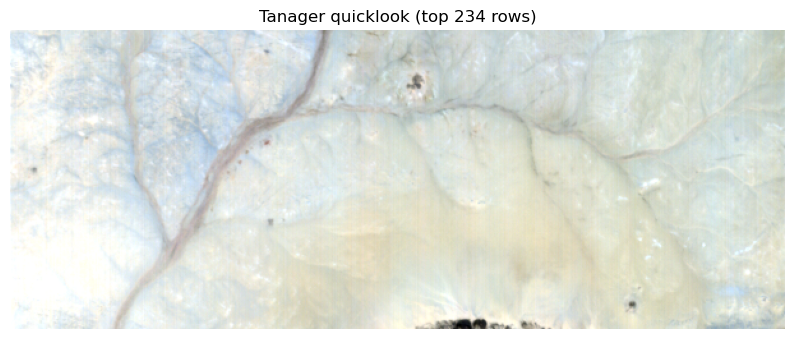

In [17]:

import matplotlib.pyplot as plt
from scripts.satellites import tanager_utils

cfg0 = SCENE_CONFIGS[0]
path0 = cfg0["inputs"][0]
cube = tanager_utils.load_tanager_cube(path0, dataset_path=tanager_utils.TANAGER_TOA_RADIANCE_DATASET)
rows, cols = cube.data.shape[1:]
rows_keep = int(rows * 0.4)
roi_spec = cfg0.get("roi")
if roi_spec:
    # trust explicit ROI if provided
    _, y_part = roi_spec.split(",")
    y0, y1 = [int(v) for v in y_part.split(":")]
    rows_keep = y1 - y0

rgb = tanager_utils.quicklook_rgb(cube, mask_name="nodata_pixels", max_size=1200)
rgb_clip = rgb[:rows_keep, :, :]
print(f"Cube shape: {cube.data.shape}, using first {rows_keep} rows for SNR.")
print(f"Quicklook shape (clipped): {rgb_clip.shape}")

plt.figure(figsize=(10, 5))
plt.imshow(rgb_clip)
plt.title(f"Tanager quicklook (top {rows_keep} rows)")
plt.axis("off")
plt.show()



## Run Experiments
Iterate through `SCENE_CONFIGS`, call `run_snr_experiment`, and stop early if any run fails.


In [18]:

results = []
for cfg in SCENE_CONFIGS:
    result = run_snr_experiment(**cfg)
    results.append((cfg, result))
    if result.returncode != 0:
        print("Aborting due to non-zero return code.")
        break
results


Running: /home/esivla/miniconda3/envs/hygasMF/bin/python -m scripts.snr_experiment --sensor tanager --input /mnt/d/Lavoro/Assegno_Ricerca_Sapienza/CLEAR_UP/CH4_detection/Matched_filter_approach/hygas/test_data/tanager/20250509_090323_87_4001/basic_radiance_hdf5__20250509_090323_87_4001_basic_radiance_hdf5.h5 --roi 0:607,0:234 --bands 1000:2500 --cases A,B,C,D,E,F,G,H --outdir /mnt/d/Lavoro/Assegno_Ricerca_Sapienza/CLEAR_UP/CH4_detection/Matched_filter_approach/hygas/notebooks/outputs --mask-frac 0.12 --diff-axis columns --k-pca 4
Finished in 47.4s; returncode=0
--- stdout ---SNR experiment completed. Outputs stored in /mnt/d/Lavoro/Assegno_Ricerca_Sapienza/CLEAR_UP/CH4_detection/Matched_filter_approach/hygas/notebooks/outputs/tanager/basic_radiance_hdf5__20250509_090323_87_4001_basic_radiance_hdf5

--- stderr ---/mnt/d/Lavoro/Assegno_Ricerca_Sapienza/CLEAR_UP/CH4_detection/Matched_filter_approach/hygas/scripts/diagnostics/striping.py:207: RuntimeWarning: Mean of empty slice
  mean_orig

[({'sensor': 'tanager',
   'inputs': ['/mnt/d/Lavoro/Assegno_Ricerca_Sapienza/CLEAR_UP/CH4_detection/Matched_filter_approach/hygas/test_data/tanager/20250509_090323_87_4001/basic_radiance_hdf5__20250509_090323_87_4001_basic_radiance_hdf5.h5'],
   'roi': '0:607,0:234',
   'bands': '1000:2500',
   'cases': 'A,B,C,D,E,F,G,H',
   'extra_args': ['--mask-frac',
    '0.12',
    '--diff-axis',
    'columns',
    '--k-pca',
    '4']},
  CompletedProcess(args=['/home/esivla/miniconda3/envs/hygasMF/bin/python', '-m', 'scripts.snr_experiment', '--sensor', 'tanager', '--input', '/mnt/d/Lavoro/Assegno_Ricerca_Sapienza/CLEAR_UP/CH4_detection/Matched_filter_approach/hygas/test_data/tanager/20250509_090323_87_4001/basic_radiance_hdf5__20250509_090323_87_4001_basic_radiance_hdf5.h5', '--roi', '0:607,0:234', '--bands', '1000:2500', '--cases', 'A,B,C,D,E,F,G,H', '--outdir', '/mnt/d/Lavoro/Assegno_Ricerca_Sapienza/CLEAR_UP/CH4_detection/Matched_filter_approach/hygas/notebooks/outputs', '--mask-frac', '0.12


## Inspect Outputs
List the generated CSV/PNG artefacts beneath `DEFAULT_OUTDIR / "tanager"` and preview representative diagnostics.


Found 8 CSV files, 1 SNR overview plots, 1 striping diagnostics, and 2 PCA summaries.

#### SNR overview

**basic_radiance_hdf5__20250509_090323_87_4001_basic_radiance_hdf5 / snr_cases_overview.png**

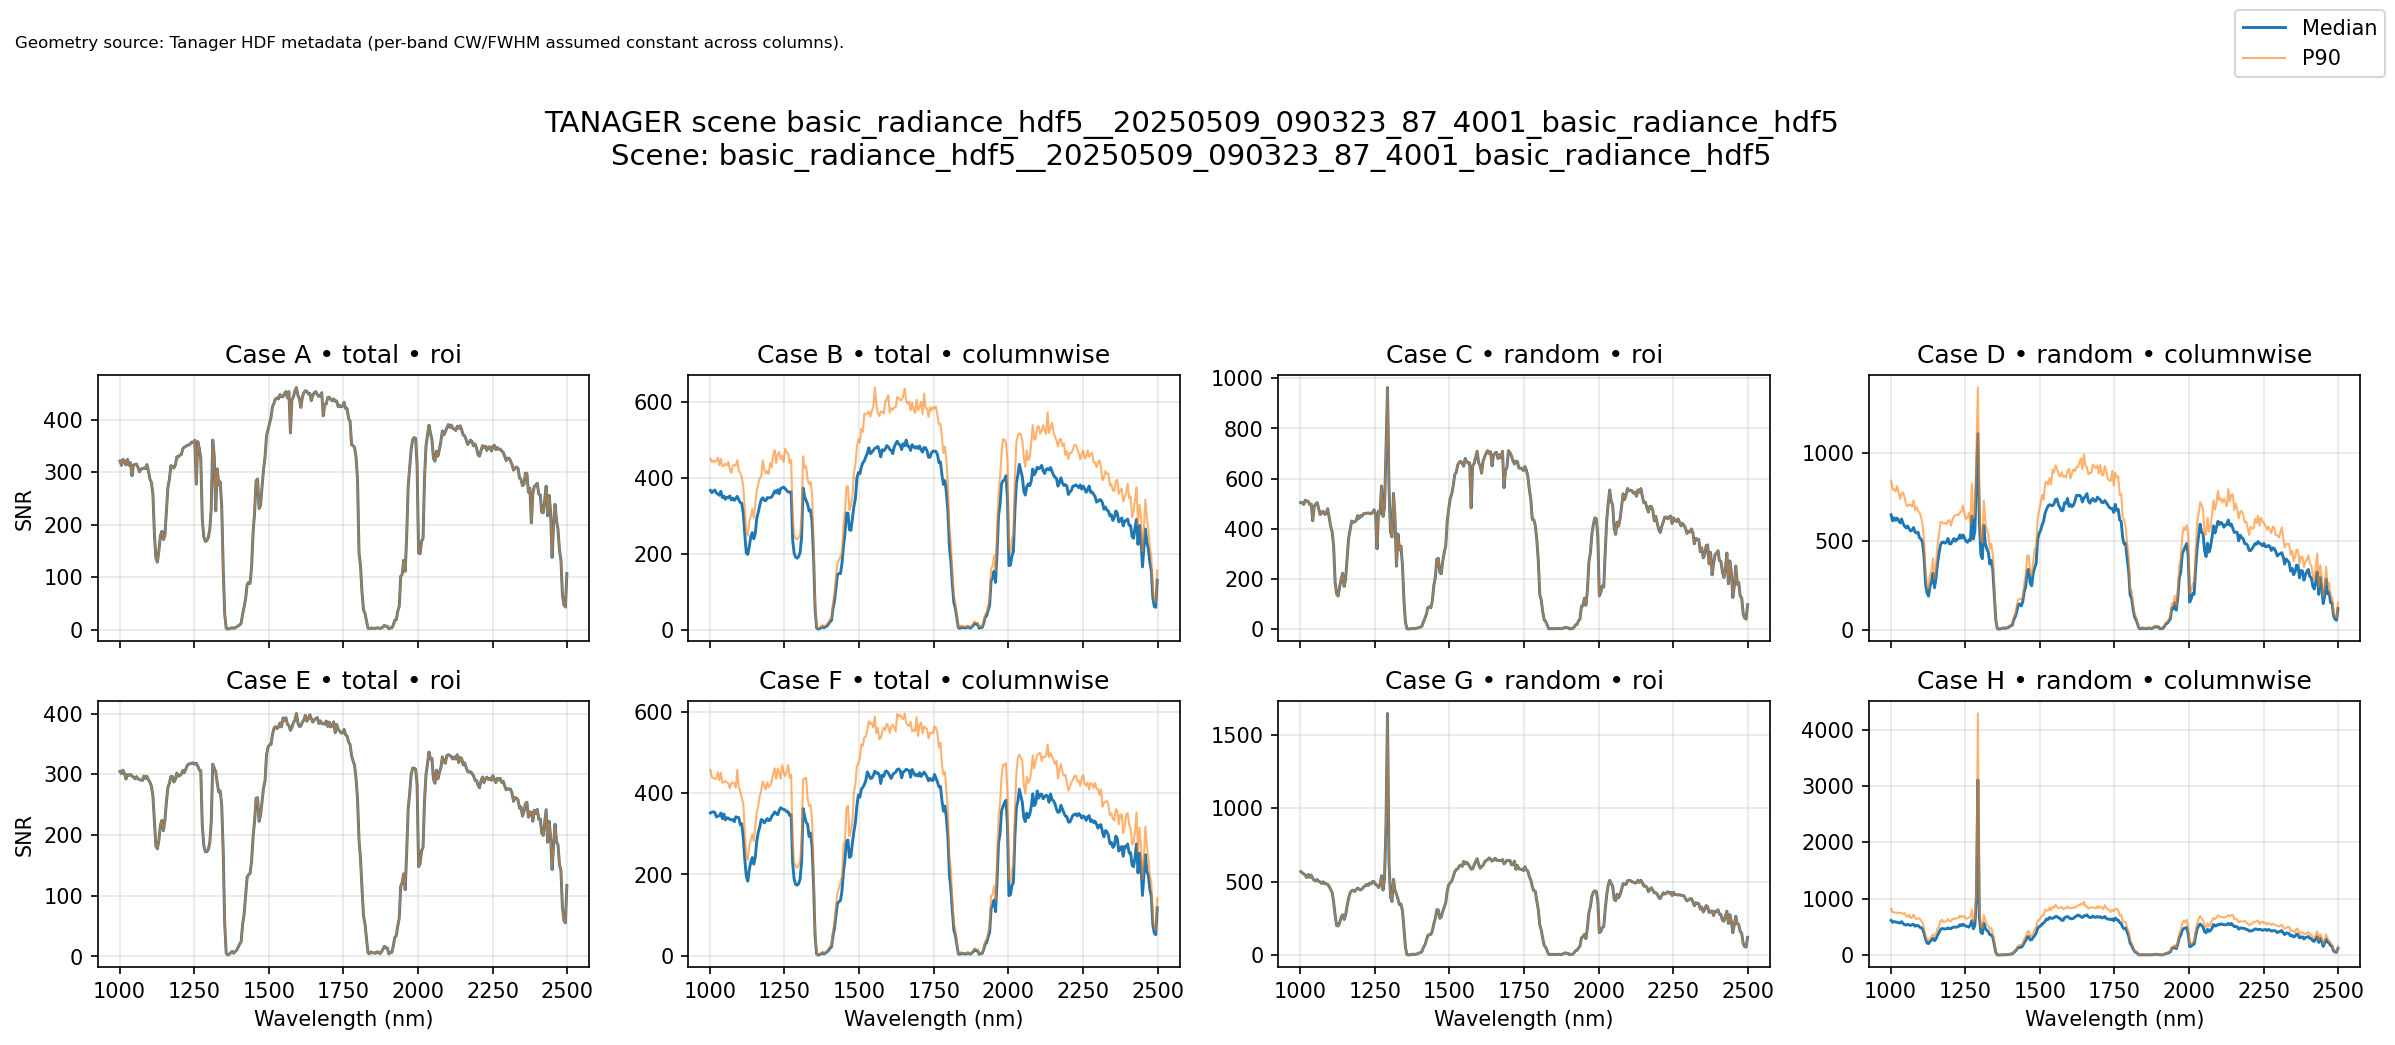

#### Striping diagnostics

**basic_radiance_hdf5__20250509_090323_87_4001_basic_radiance_hdf5 / striping_diagnostics.png**

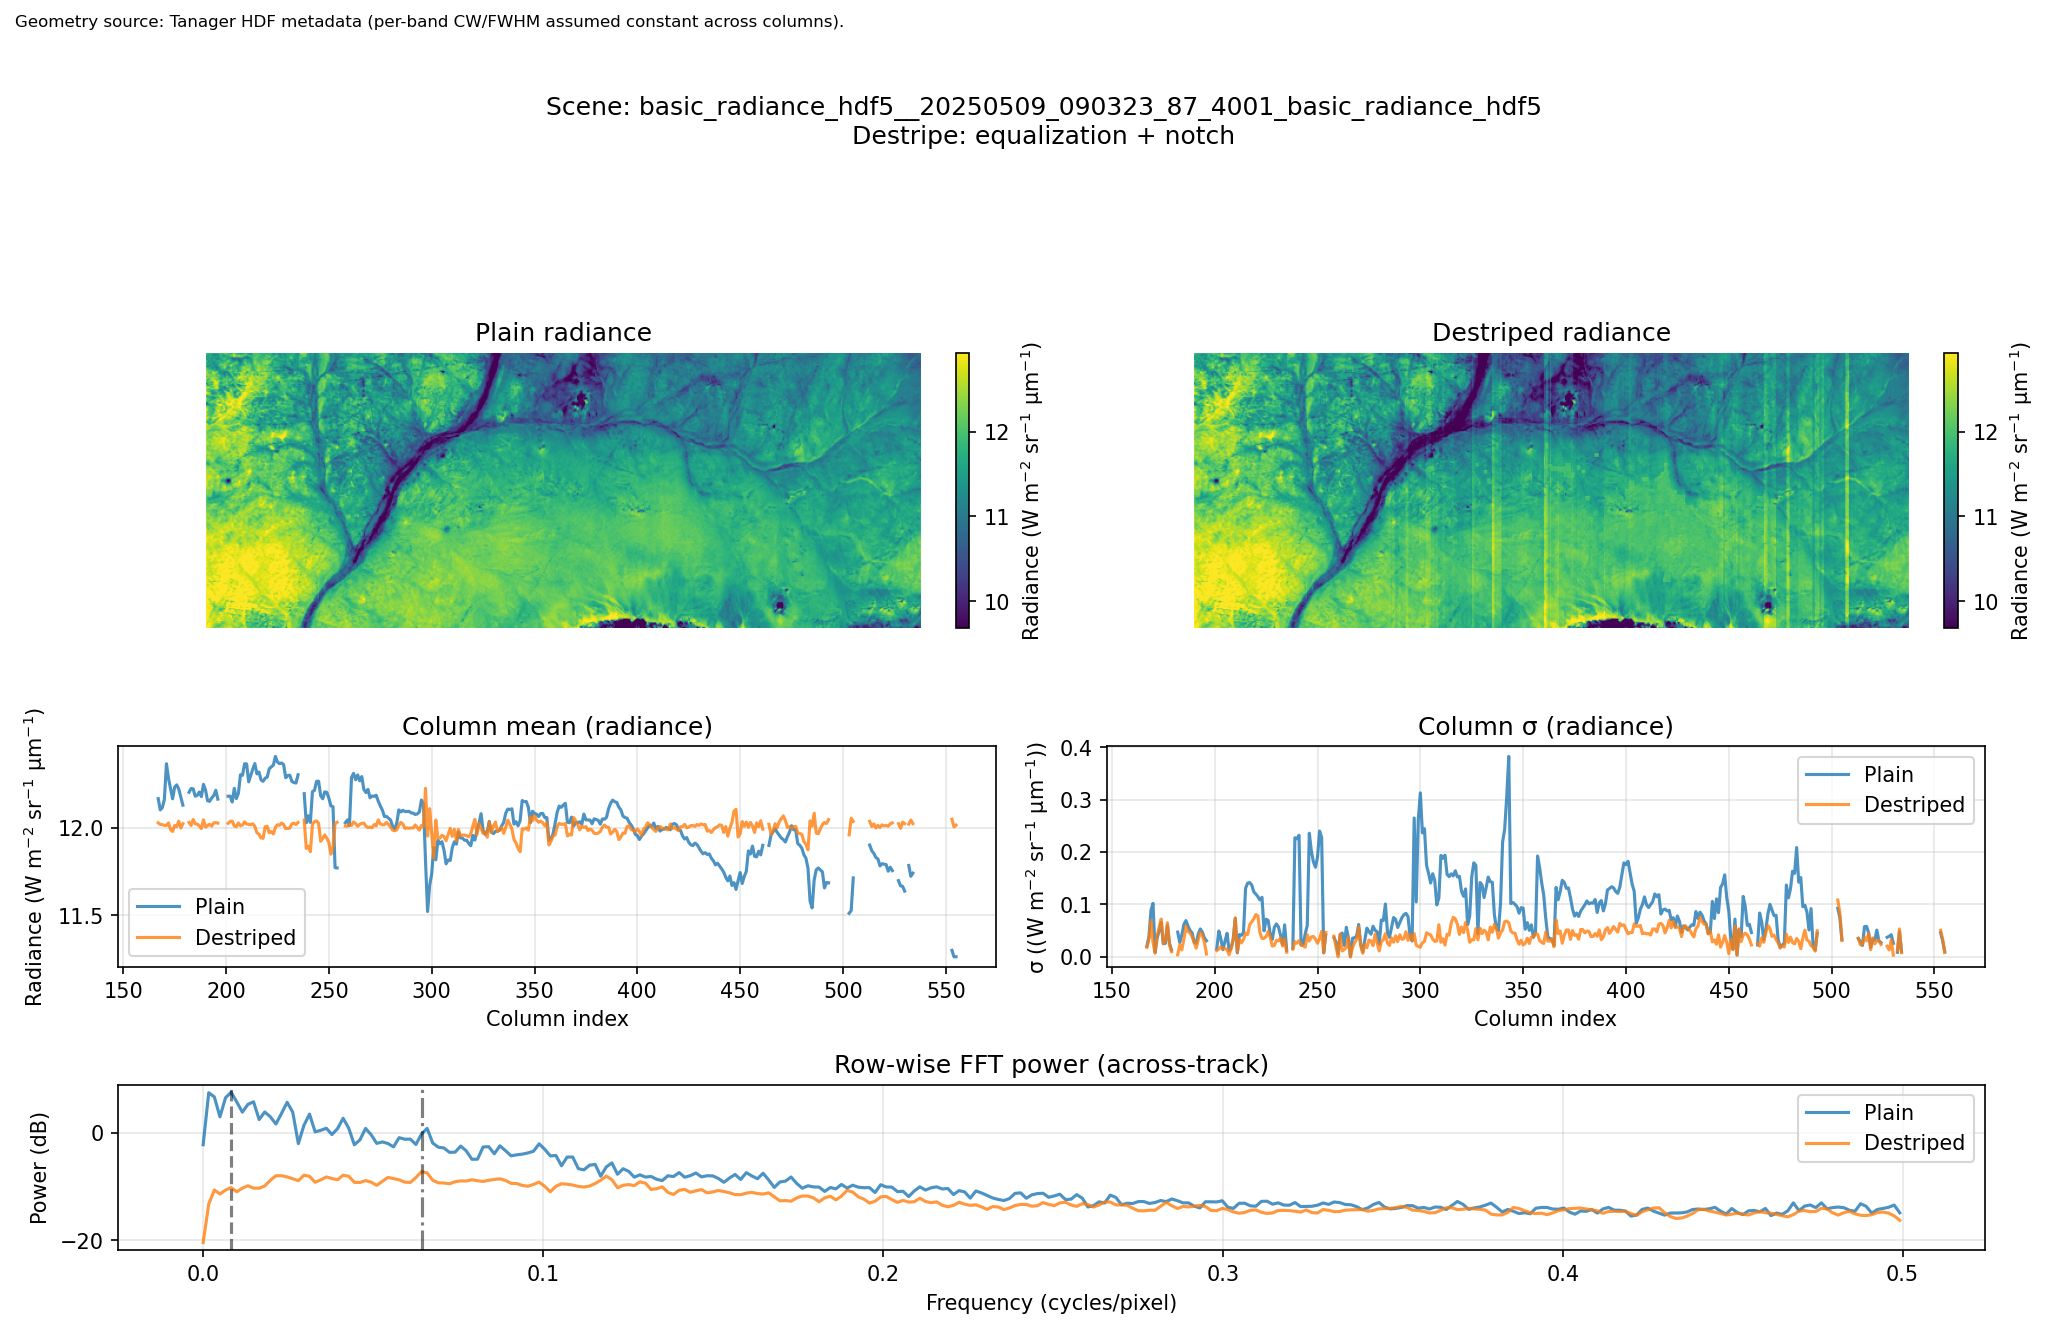

#### PCA summaries

**basic_radiance_hdf5__20250509_090323_87_4001_basic_radiance_hdf5 / pca_summary_destriped.png**

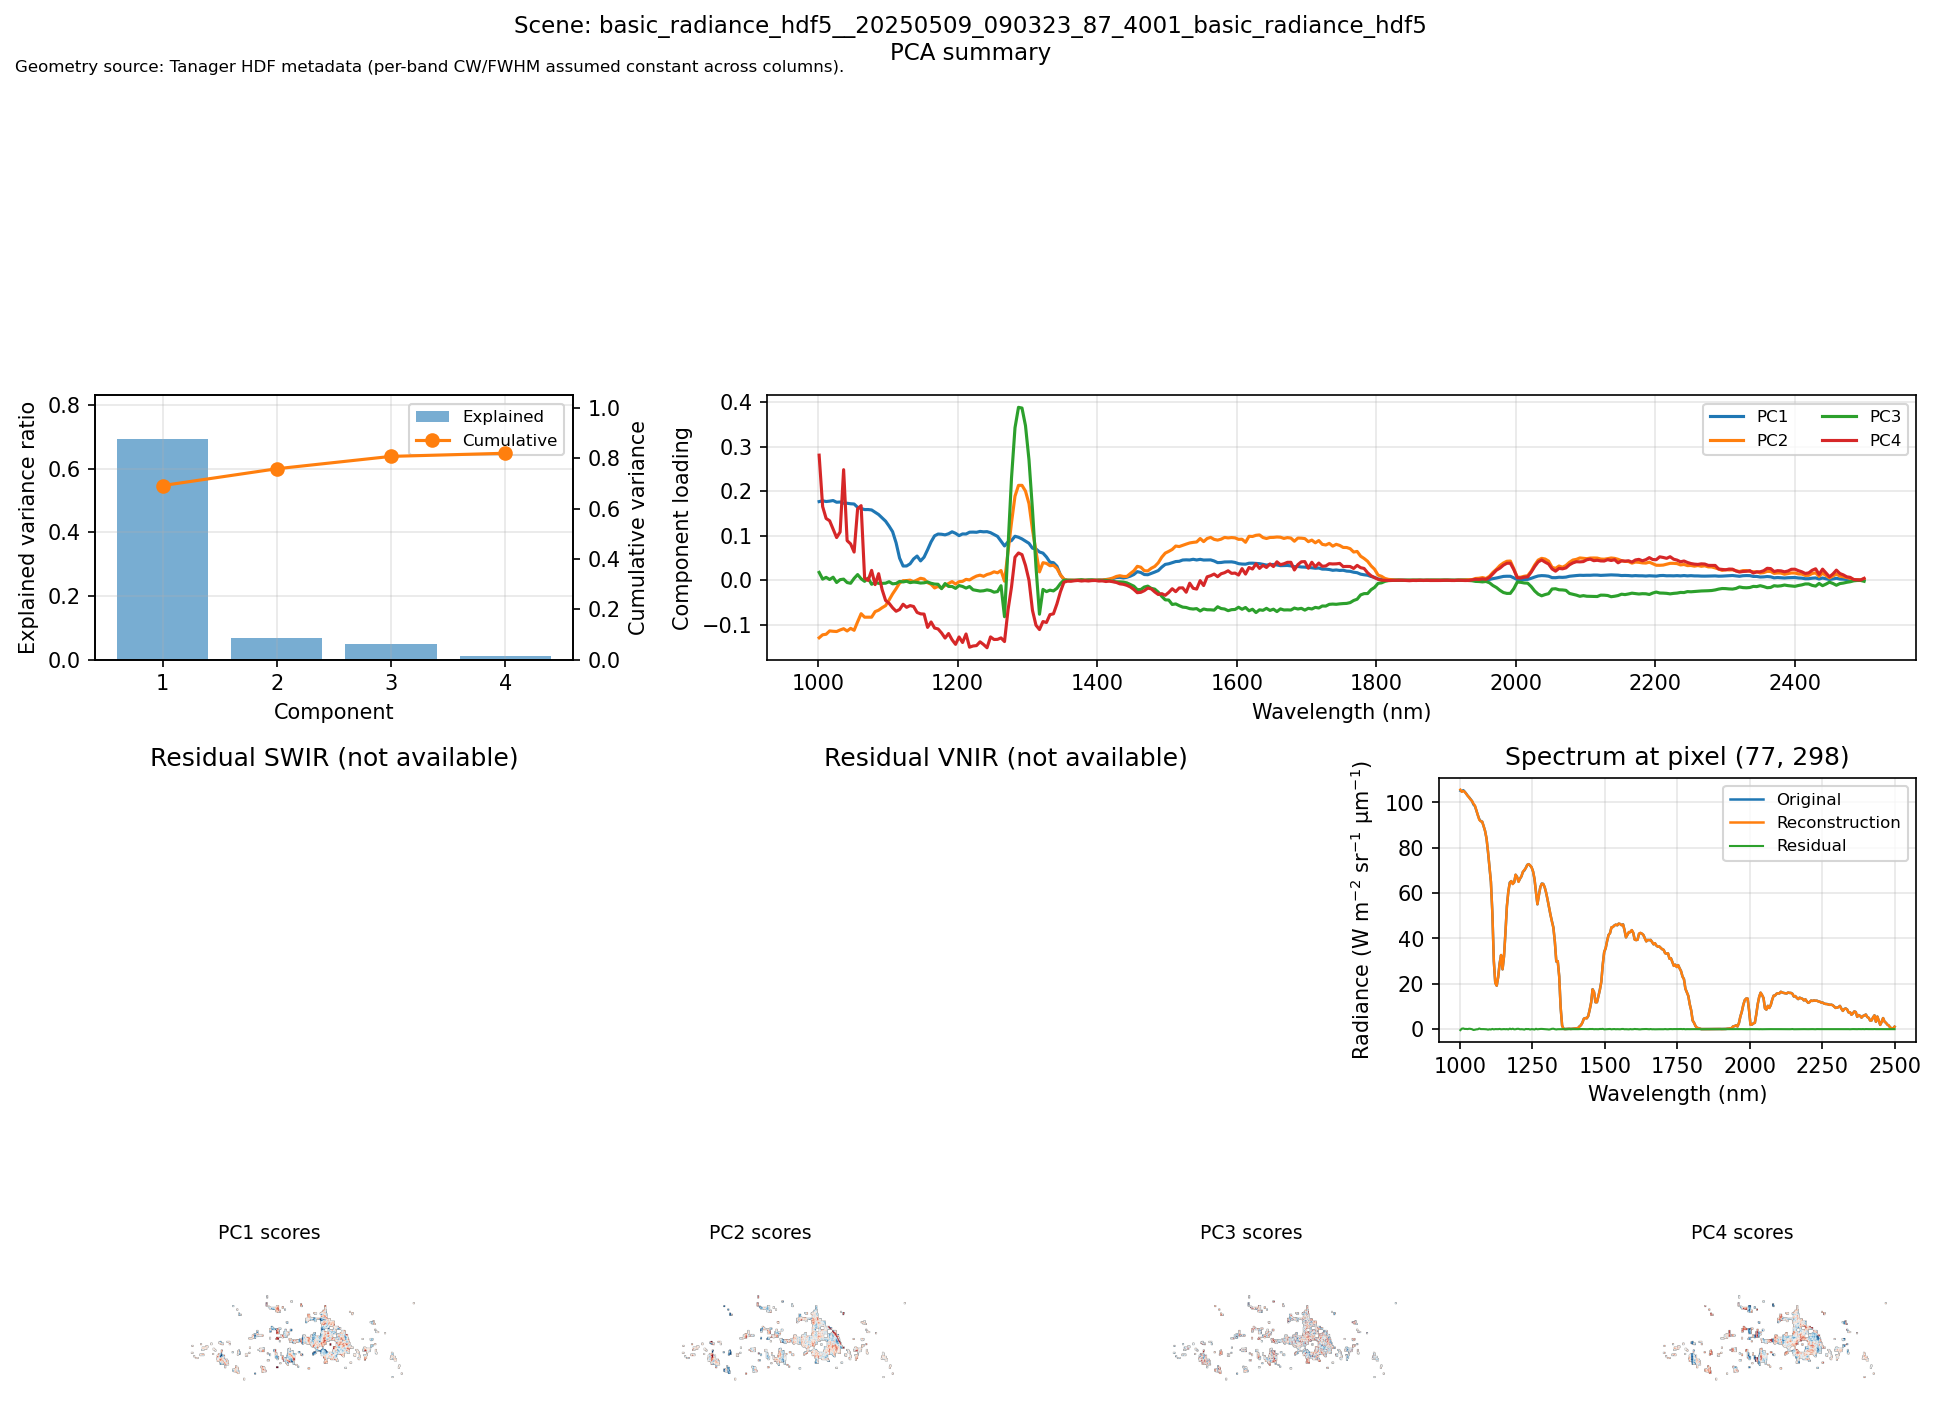

**basic_radiance_hdf5__20250509_090323_87_4001_basic_radiance_hdf5 / pca_summary_plain.png**

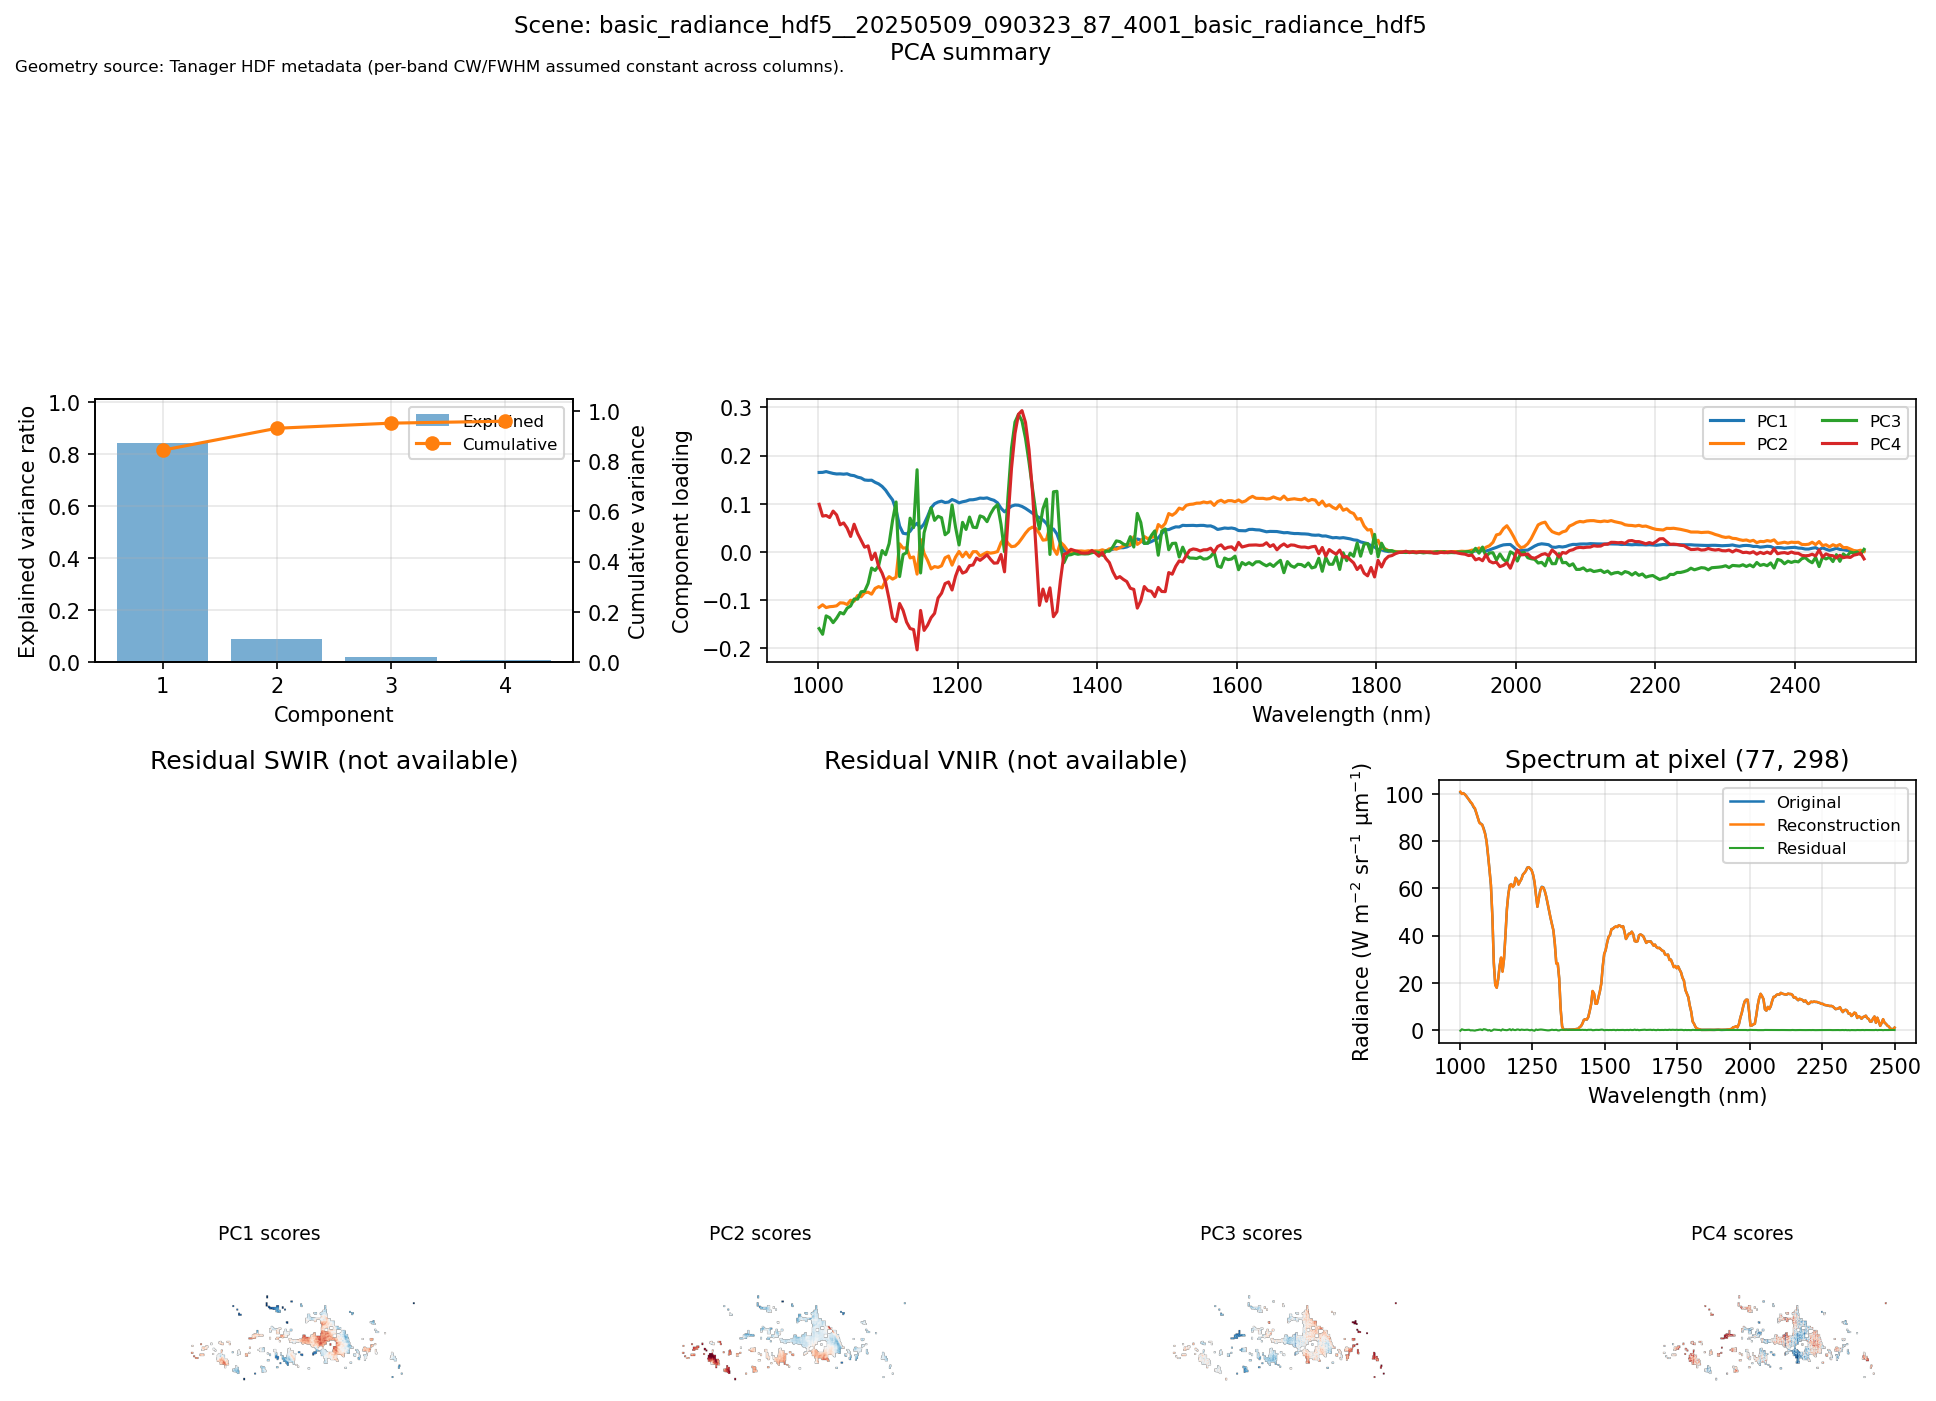

In [19]:

from IPython.display import Image, display
from glob import glob

output_root = (DEFAULT_OUTDIR / "tanager")
output_root.mkdir(parents=True, exist_ok=True)
if output_root.exists():
    csv_paths = sorted(output_root.glob("**/snr_cases_*.csv"))
    overview_pngs = sorted(output_root.glob("**/snr_cases_overview.png"))
    striping_pngs = sorted(output_root.glob("**/striping_diagnostics.png"))
    pca_pngs = sorted(output_root.glob("**/pca_summary_*.png"))
    display(Markdown(
        f"Found {len(csv_paths)} CSV files, {len(overview_pngs)} SNR overview plots, "
        f"{len(striping_pngs)} striping diagnostics, and {len(pca_pngs)} PCA summaries."
    ))
    if overview_pngs:
        display(Markdown("#### SNR overview"))
        for png in overview_pngs:
            display(Markdown(f"**{png.parent.relative_to(output_root)} / {png.name}**"))
            display(Image(filename=png, width=900))
    if striping_pngs:
        display(Markdown("#### Striping diagnostics"))
        for png in striping_pngs:
            display(Markdown(f"**{png.parent.relative_to(output_root)} / {png.name}**"))
            display(Image(filename=png, width=900))
    if pca_pngs:
        display(Markdown("#### PCA summaries"))
        for png in pca_pngs:
            display(Markdown(f"**{png.parent.relative_to(output_root)} / {png.name}**"))
            display(Image(filename=png, width=900))
